In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy 
from scipy import interpolate
from scipy import integrate
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
from matplotlib.patches import Patch
import matplotlib.ticker as mticker

In [2]:
import lmod
await lmod.purge(force=True)
await lmod.load('texlive/2018.06.15-fasrc01')

In [3]:
from other_limits.Nlimits import *
from other_limits.DPlimits import *

In [4]:
save_folder = '../fig/7_constraints_comparison/'
!mkdir -p $save_folder

# Global defs

In [5]:
from matplotlib import rc, rcParams
## Plot the parameter space
fsize = 12
rcParams['text.usetex'] = True
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern Roman', 'serif']
rcParams['figure.figsize'] = (1.2*3.7,1.2*2.3617)
# rcParams['lines.linewidth'] = 1.0
rcParams['hatch.linewidth'] = 0.3
# rcParams['axes.linewidth'] = 0.4
rcParams['axes.labelsize'] = fsize
# rcParams['xtick.direction'] = 'in'
# rcParams['xtick.major.width'] = 0.4
# rcParams['xtick.minor.width'] = 0.4
rcParams['xtick.labelsize'] = fsize
# rcParams['ytick.direction'] = 'in'
# rcParams['ytick.major.width'] = 0.4
# rcParams['ytick.minor.width'] = 0.4
rcParams['ytick.labelsize'] = fsize
rcParams['legend.frameon'] = False
rcParams['legend.fontsize'] = 0.8*fsize
rcParams['legend.loc'] = 'lower right'
rcParams["text.latex.preamble"] = r'''
    \usepackage{amsmath,amssymb,amsthm}
    \usepackage{siunitx}
'''

# Experimental T2K constraints

In [6]:
from Likelihood import LEff
from dark_nus_utils import load_datasets
from const import alphaQED

In [7]:
hierarchy = 'heavy'
D_or_M = 'majorana'
distance = 'log'
smoothing_pars = (0.1, 0.1)
selection = 'cut_based'

In [8]:
levels = {0.68: -2.3/2,
          0.9: -4.61/2,
          0.95: -5.99/2}

In [10]:
my_exp_analysis = load_datasets(hierarchy, D_or_M, fluxes=['FHC'], timeit=True, direct_load_objects=True)[f'{hierarchy}_{D_or_M}_FHC']

heavy majorana FHC
Wall time: 0.8933372497558594 s, CPU time: 0.8923606250000002


In [11]:
from ctau_utils import ctau_heavy
def heavy_nonminimal_posterior(m4=0.1, mz=1.25, Umu4_2=2.2e-7, Ud4_2=0.01, alpha_d=0.4, epsilon=2.1e-2, additional_efficiency=0.1):
    Vmu4_alpha_epsilon2 = alpha_d * Umu4_2 * alphaQED * epsilon**2
    Valpha4_alpha_epsilon2 = alpha_d * Ud4_2 * alphaQED * epsilon**2
    ctau = ctau_heavy(m4, 
                      mz, 
                      Valpha4_alpha_epsilon2, 
                      D_or_M)
    this_mu = Vmu4_alpha_epsilon2/my_exp_analysis.Vmu4_alpha_epsilon2
    mu, sigma2 = my_exp_analysis.kde_n_events(df=my_exp_analysis.df_base.query(selection),
                                                     m4mz=(m4, mz),
                                                     ctau=ctau,
                                                     mu=this_mu,
                                                     distance=distance,
                                                     smoothing=smoothing_pars)
    mu *= additional_efficiency
    sigma2 *= additional_efficiency**2
    return LEff(0, mu, sigma2), mu, sigma2, ctau

In [12]:
heavy_nonminimal_posterior_v = np.vectorize(heavy_nonminimal_posterior)

### T2K constrain calculation

In [13]:
# setting
mz = np.geomspace(0.101, my_exp_analysis.mz_limits[1], 10)
epsilon = np.geomspace(1e-5, 1e-1, 8)
mz, epsilon = np.meshgrid(mz, epsilon)

dark_photon_Ud4_2_s = [1, 1e-2, 1e-4]

In [14]:
# calculation
t2k_dark_photon_constraints = {}
for Ud4_2 in dark_photon_Ud4_2_s:
    t2k_dark_photon_constraints[Ud4_2] = heavy_nonminimal_posterior_v(mz=mz, epsilon=epsilon, Ud4_2=Ud4_2)

## DARK PHOTON PARAMETER SPACE

In [15]:
X_MIN, X_MAX = 1e-2, 1e1
Y_MIN, Y_MAX = 1e-6, 0.05

mzpr = np.geomspace(X_MIN, X_MAX, 1000)

this_m4 = 0.1

## g-2 definitions

In [16]:
FNAL_run_combined = gminus2.weighted_average(gminus2.DELTA_FNAL, gminus2.DELTA_BNL)

In [17]:
energy, one_over_alpha = np.loadtxt("./other_limits/DPlimits/digitized/alphaQED/alpha_QED_running_posQ2.dat", unpack = True)
one_over_alpha_ew = interpolate.interp1d(energy, one_over_alpha, kind = "linear")

FACTOR = 1/2/np.pi/one_over_alpha_ew(gminus2.M_MU)

gminus2_sigmas = [2.]
gminus2_colors = ['dodgerblue']

## dark photon plot

In [18]:
from const import alphaQED
ctau_heavy(m4=0.1, 
           mz=2, 
           Valpha4_alphaepsilon2=1*0.4*alphaQED*(2e-3)**2, 
           D_or_M='majorana')

203.8835819903886

Text(1.0, 1.0, 'Preliminary')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


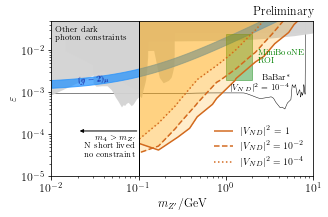

In [19]:
fig = plt.figure()
axes_form = [0.14,0.15,0.82,0.76]
ax = fig.add_axes(axes_form)
ax.set_xlim(X_MIN, X_MAX)
ax.set_ylim(Y_MIN, Y_MAX)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$m_{Z^\prime}/$GeV')
ax.set_ylabel(r'$\varepsilon$')
    
semi_visible_DP.plot_constraints(ax, X_MIN, X_MAX, separated=False)

gminus2.compute_and_plot_gminus2_region(
    ax = ax,
    mz = mzpr,
    delta_amu = FNAL_run_combined[0],
    error = FNAL_run_combined[1],
    factor = FACTOR,
    sigmas = gminus2_sigmas,
    colors = gminus2_colors
)

ax.axvline(x=this_m4, color='black', lw=1)
ax.annotate('', xy=(2e-2, 1.2e-4), xytext=(this_m4, 1.2e-4), 
            arrowprops=dict(arrowstyle="-|>", mutation_scale=7, color='black', lw=1))

ax.annotate(r"$m_{4} > m_{Z'}$"+'\nN short lived\nno constraint', 
            xy=(9e-2, 3e-5), 
            fontsize=0.7*fsize, 
            color='black', 
            horizontalalignment='right')
ax.annotate(r'$(g-2)_\mu$', xy=(2e-2,1.6e-3), rotation=4, fontsize=0.7*fsize, color='darkblue')

# miniboone ROI
plt.fill_between([1, 2], [2e-3, 2e-3], [2.5e-2, 2.5e-2], color='green', alpha=0.4)
ax.annotate('MiniBooNE\nROI', xy=(2.3, 5e-3), fontsize=0.7*fsize, color='green')

# plot T2K constraint
colors = ['orange', 'orange', 'orange']
linestyles = ['-', '--', 'dotted']

contours = {}
for Ud4_2, linestyle, color in zip(dark_photon_Ud4_2_s, linestyles, colors):
    plt.contourf(mz, epsilon, 
                                  t2k_dark_photon_constraints[Ud4_2][0], levels=[-np.inf, levels[0.9]], 
                                  colors=[color], linestyles=[linestyle], alpha=0.2)
    contours[Ud4_2] = plt.contour(mz, epsilon, 
                                  t2k_dark_photon_constraints[Ud4_2][0], levels=[levels[0.9]], 
                                  colors=['chocolate'], linestyles=[linestyle])
plt.legend([cntr.legend_elements()[0][0] for cntr in contours.values()], 
            [f'$|V_{{ND}}|^2$ = {Ud4_2}' if Ud4_2==1 else r'$|V_{{ND}}|^2 = 10^{'+f'{np.log10(Ud4_2):.1g}'+r'}$' for Ud4_2 in contours.keys()],
           frameon=False,
           loc='lower right')

ax.set_xlim(X_MIN,X_MAX)
ax.set_ylim(bottom=1e-5)

ax.set_title('Preliminary', loc='right', style='italic')
# fig.savefig(f"{save_folder}dark_photon.pdf", bbox_inches='tight', transparent=True)
# fig.savefig(f"{save_folder}dark_photon.png", dpi=250, bbox_inches='tight', transparent=True)

## Heavy neutrino parameter space

In [20]:
################################
# range of N mass
MN_MIN = 1e-3 # GeV
MN_MAX = 2 # GeV
MN = np.logspace(np.log10(MN_MIN),np.log10(MN_MAX),1000)

### Computation of T2K constraints varying $|U_{D4}|^2$

In [21]:
# setting
m4 = np.geomspace(my_exp_analysis.m4_limits[0],
                  my_exp_analysis.m4_limits[1],
                  45)
Umu4_2 = np.geomspace(1e-11,
                      1,
                      40)
m4, Umu4_2 = np.meshgrid(m4, Umu4_2)

hnl_Ud4_2_s = [1, 1e-2, 1e-4]

In [36]:
# calculation
t2k_hnl_constraints = {}
for Ud4_2 in hnl_Ud4_2_s:
    t2k_hnl_constraints[Ud4_2] = heavy_nonminimal_posterior_v(m4=m4, Umu4_2=Umu4_2, Ud4_2=Ud4_2)

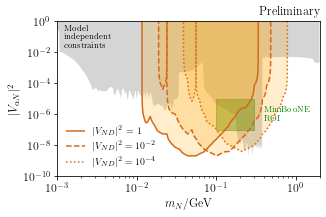

In [37]:
fig = plt.figure()
axes_form = [0.14,0.15,0.82,0.76]
ax = fig.add_axes(axes_form)
ax.set_xlim(X_MIN, X_MAX)
ax.set_ylim(Y_MIN, Y_MAX)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"$m_{N}$/GeV")
ax.set_ylabel(r'$|V_{\alpha N}|^2$')

usqr_bound = umu4.USQR(MN)
usqr_bound_inv = umu4.USQR_inv(MN)

##############################################
# Constraints on U\alpha4^2
# Minimal HNL -- no Zprime and all that
# ax.plot(MN, usqr_bound, color='navy', )
# ax.fill_between(MN, usqr_bound, np.ones(np.size(MN)), 
#             fc='dodgerblue', ec='None', lw =0.0, alpha=0.5, label=r'all bounds')

# most model independent bounds
# ax.plot(MN, usqr_bound_inv, color='navy', lw=1)
ax.fill_between(MN, usqr_bound_inv, np.ones(np.size(MN)), 
            fc='lightgrey', ec='None', lw =0.0, alpha=0.95)
ax.annotate('Model\nindependent\nconstraints', xy=(0.0012, 0.02), rotation=0, fontsize=0.7*fsize, color='black')

# MiniBooNE ROI
plt.fill_between([0.100, 0.300], [1e-7, 1e-7], [1e-5, 1e-5], color='green', alpha=0.4)
ax.annotate('MiniBooNE\nROI', xy=(0.4, 4e-7), fontsize=0.7*fsize, color='green')

# plot T2K constraints
colors = ['orange', 'orange', 'orange']
linestyles = ['-', '--', 'dotted']
contours = {}
for Ud4_2, linestyle, color in zip(hnl_Ud4_2_s, linestyles, colors):
    ax.contourf(m4, Umu4_2, 
                                  t2k_hnl_constraints[Ud4_2][0], levels=[-np.inf, levels[0.9]], 
                                  colors=[color], linestyles=[linestyle], alpha=0.2)
    contours[Ud4_2] = ax.contour(m4, Umu4_2, 
                                  t2k_hnl_constraints[Ud4_2][0], levels=[levels[0.9]], 
                                  colors=['chocolate'], linestyles=[linestyle])
ax.legend([cntr.legend_elements()[0][0] for cntr in contours.values()], 
            [f'$|V_{{ND}}|^2$ = {Ud4_2}' if Ud4_2==1 else r'$|V_{{ND}}|^2 = 10^{'+f'{np.log10(Ud4_2):.1g}'+r'}$' for Ud4_2 in contours.keys()],
           frameon=False,
           loc='lower left')


ax.set_xlim(MN_MIN,MN_MAX)
ax.set_ylim(1e-10,1)
ax.loglog()

ax.set_yticks([1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 1])

ax.set_title('Preliminary', loc='right', style='italic')
fig.savefig(f"{save_folder}hnl_umu4sqr_vs_mn.pdf", bbox_inches='tight', transparent=True)
fig.savefig(f"{save_folder}hnl_umu4sqr_vs_mn.png", dpi=250, bbox_inches='tight', transparent=True)